#ALL IMPORTS

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [2]:
%ls Archive/

EuroSAT/         EuroSATallBands/ SatData/


In [3]:
data_dir = 'Archive/SatData/'
print(os.listdir(data_dir))

['cloudy', '.DS_Store', 'water', 'green_area', 'desert']


## CUSTOM DATA LOADER

In [4]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"desert" : 0, "water": 1,"green_area": 2,"cloudy": 3}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

##SPLITTING DATA

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [6]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['Archive/SatData/cloudy', 'Archive/SatData/water', 'Archive/SatData/green_area', 'Archive/SatData/desert']
[['Archive/SatData/cloudy/train_17406.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_23953.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_34585.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_16042.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_18084.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_34208.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_4641.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_4127.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_4133.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_31358.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_17610.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_827.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_16240.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_35499.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_31600.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_10816.jpg', 'cloudy'], ['Archive/SatData/cloudy/train_3

### PLOTING DATA

In [7]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


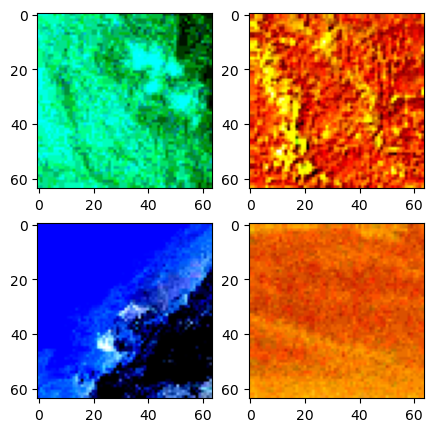

In [8]:
plot_data_loader(data_loader_test,[2,2])

###MODEL

In [9]:
 model = models.resnet18(pretrained=True)
    

/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###TRAINING LOOPS

In [11]:

optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()



In [12]:
device


device(type='mps')

In [13]:
num_epochs = 10
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        images = data[0].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/10], Step [100/113], Loss: 0.0095, Accuracy: 100.00%
Epoch [2/10], Step [100/113], Loss: 0.0787, Accuracy: 96.88%
Epoch [3/10], Step [100/113], Loss: 0.0016, Accuracy: 100.00%
Epoch [4/10], Step [100/113], Loss: 0.0228, Accuracy: 100.00%
Epoch [5/10], Step [100/113], Loss: 0.0699, Accuracy: 96.88%
Epoch [6/10], Step [100/113], Loss: 0.0018, Accuracy: 100.00%
Epoch [7/10], Step [100/113], Loss: 0.1197, Accuracy: 96.88%
Epoch [8/10], Step [100/113], Loss: 0.0250, Accuracy: 100.00%
Epoch [9/10], Step [100/113], Loss: 0.0013, Accuracy: 100.00%
Epoch [10/10], Step [100/113], Loss: 0.0053, Accuracy: 100.00%
######## Training Finished in 201.16492080688477 seconds ###########


### MODEL EVOLUTION

In [14]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 1126 test images: 79.75133214920072 %
